<a href="https://colab.research.google.com/github/farhan1503001/Deep-Learning-Rhyme-Projects/blob/main/Build_an_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with PyTorch : Build an AutoEncoder

An autoencoder is a type of neural network that learns to copy its input to its output. In autoencoder, encoder encodes the image into compressed representation, and the decoder decodes the representation.

![](denoising_autoencoder.png)

Applications of AutoEncoder:

- Segmentation
- Denoising Image
- Super Resolution Image
- Image Compression
- and many more .....

We will perform denoising task in this project

In [78]:
#Importing necessary libraries for building denoiser autoencoder
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from tqdm.notebook import tqdm 

# Exploring Dataset 

In [79]:
data = pd.read_csv("mnist_dataset.csv")
data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
image = data.iloc[12] # selecting image at index 7 
image = np.array(image).astype('float32')
image = np.reshape(image,(28,28)) # reshaping image to 28 x 28 
image = image / 255 # to scale image between 0 to 1

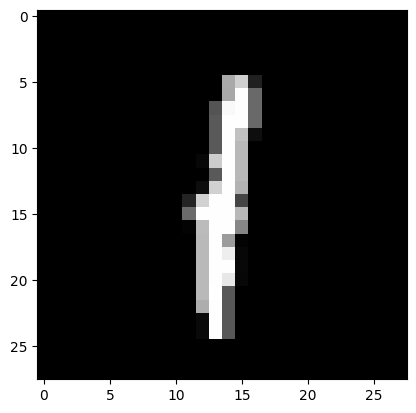

In [81]:
plt.imshow(image,cmap = "gray") 

In [82]:
noisy_image = image + 0.2 * np.random.randn(*image.shape) # Adding random noise to image 
noisy_image = np.clip(noisy_image,0,1) #ranging between 0 - 1

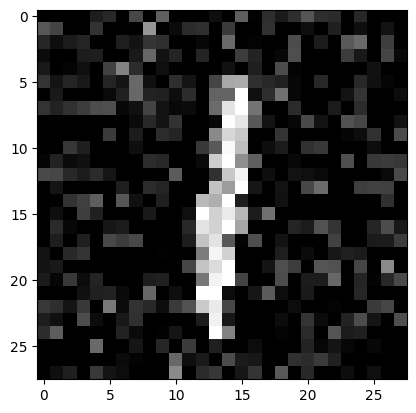

In [83]:
plt.imshow(noisy_image,cmap = "gray")

# Data Preparation 

In [84]:
#Now we will create dataset for denoising image using autoencoder
from torch.utils.data import Dataset

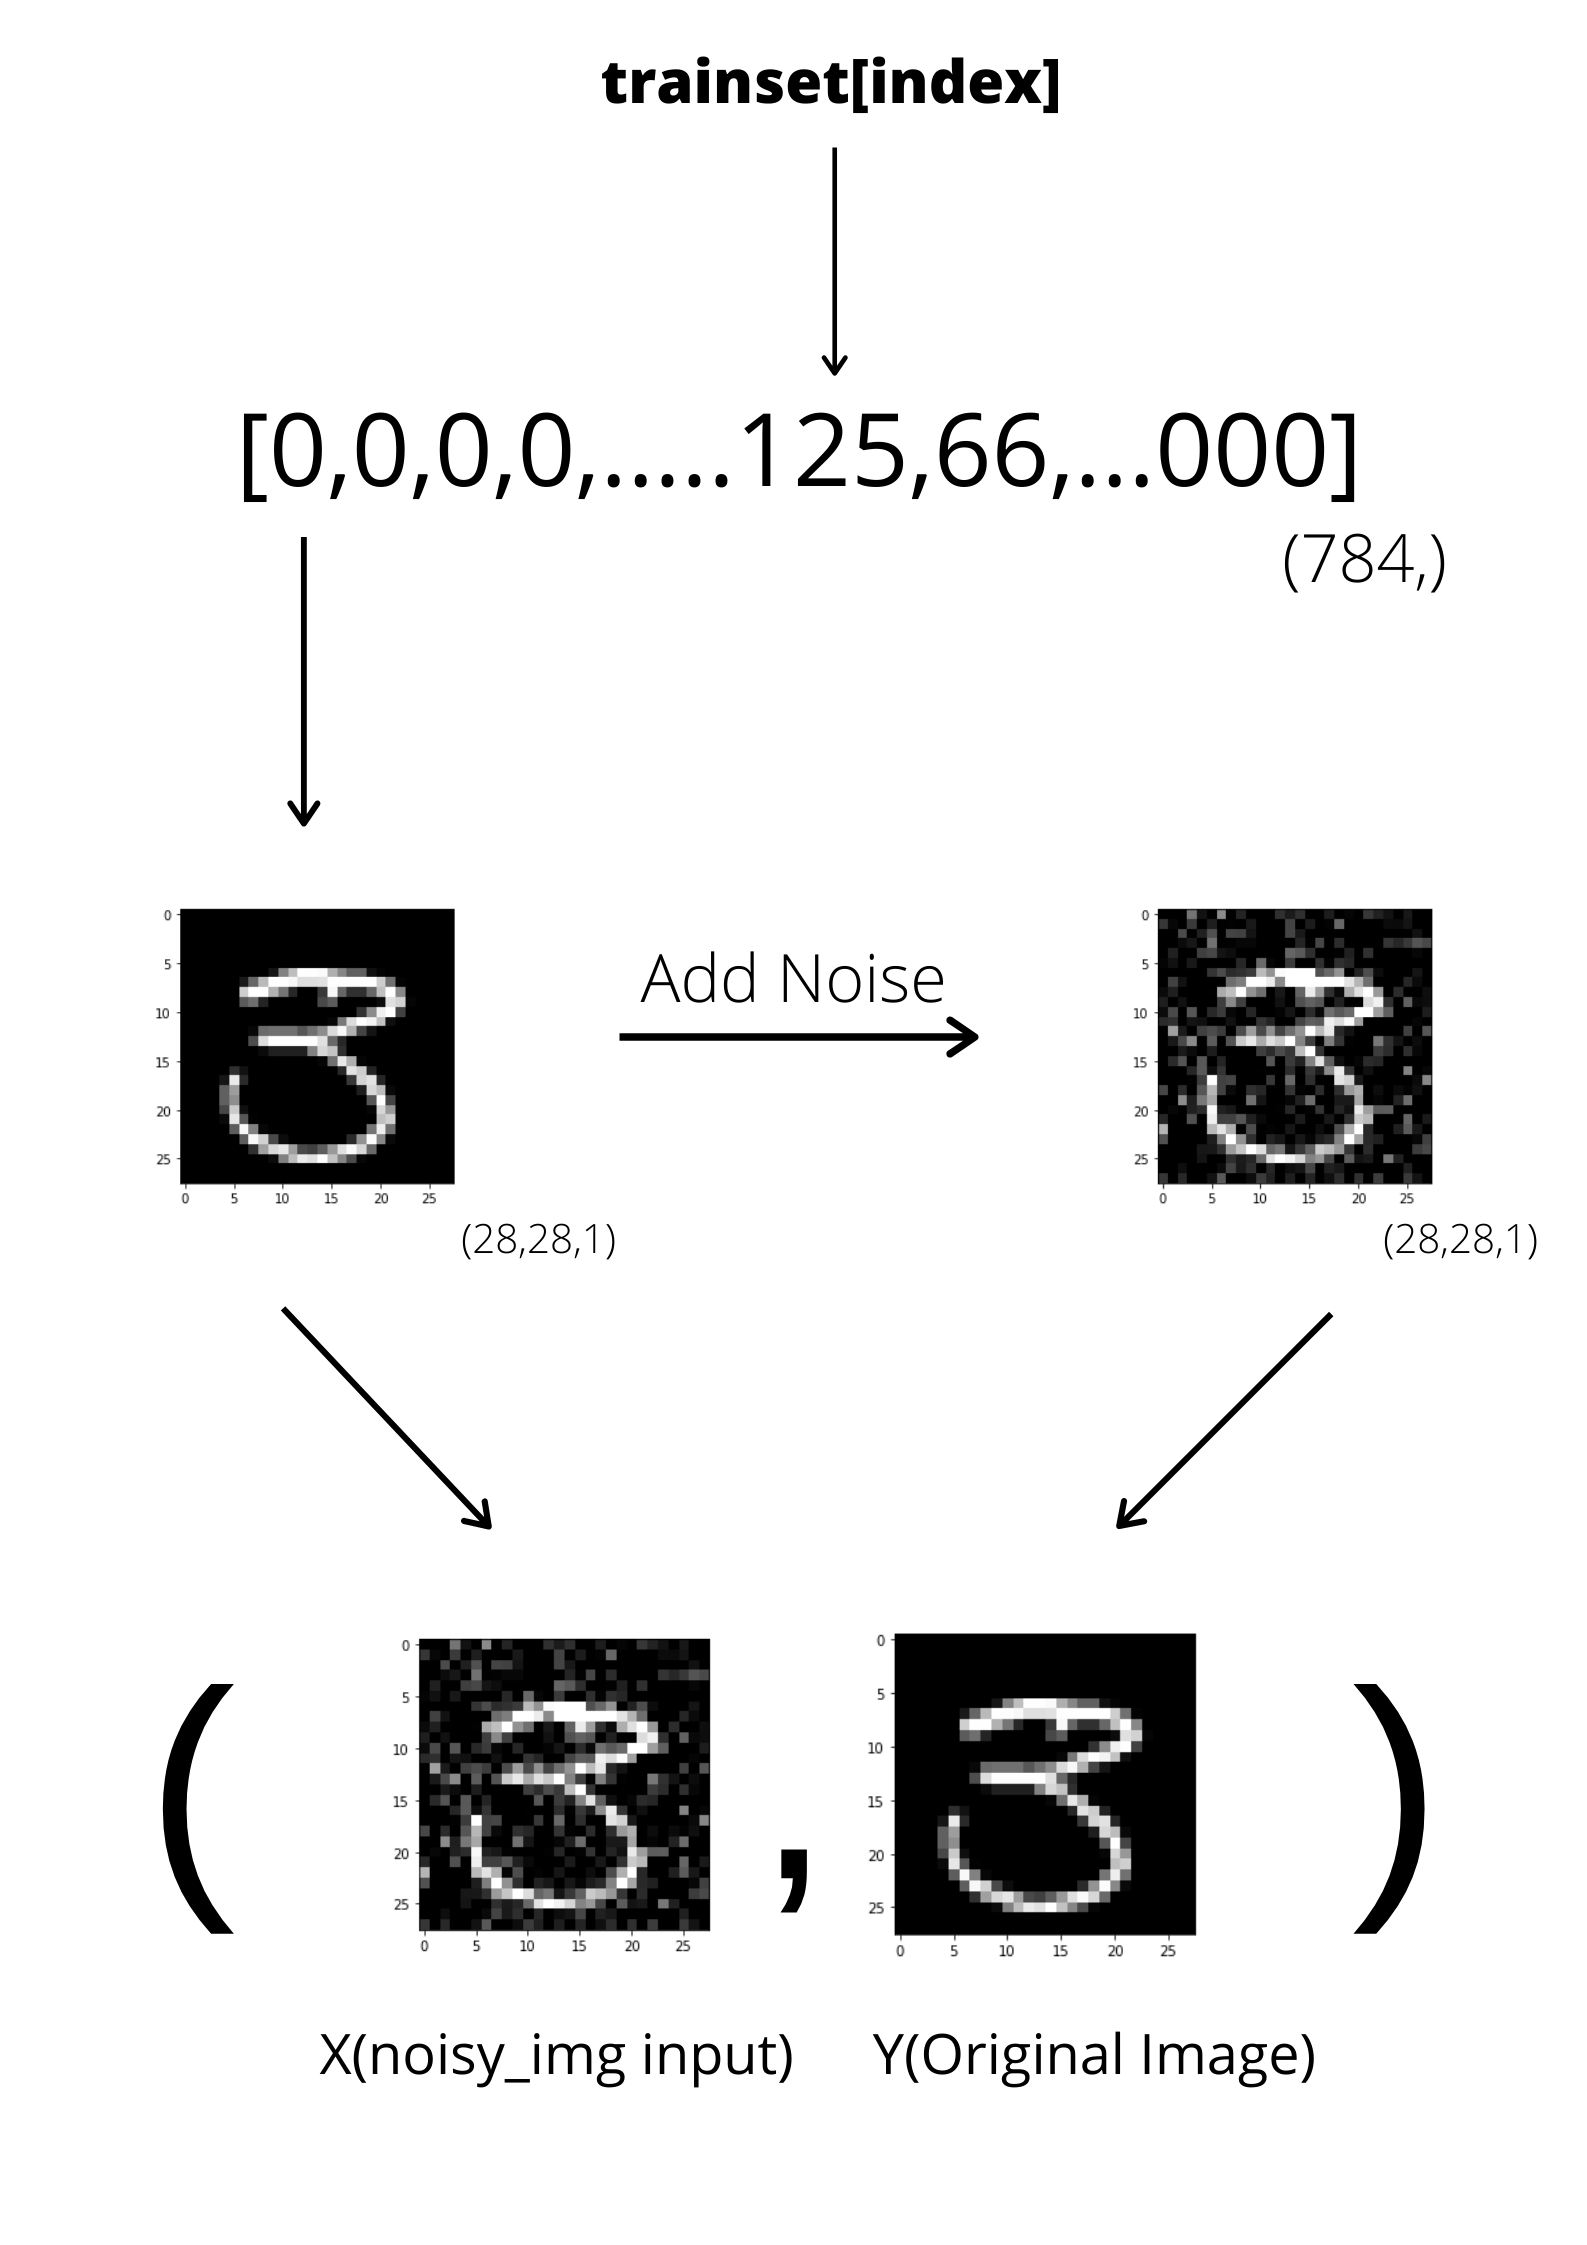

In [85]:
class MNIST_AE_Dataset(Dataset):
    
    def __init__(self,csv_file,noise_factor = 0.2,transform = None):
        
        self.data = pd.read_csv(csv_file)
        self.transform = transform 
        self.noise_factor = noise_factor
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        
        image = self.data.iloc[idx]
        image = np.array(image)
        #Reshaping image
        image=np.reshape(image,(28,28,1)) #here 1 for channel dimension
        #Now normalizing the image
        image=image/255.0
        #Now creating noisy image
        noisy_image = image + self.noise_factor * np.random.randn(*image.shape)
        noisy_image = np.clip(noisy_image,0,1)
        
        sample = (noisy_image,image)
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

For eg, numpy array image with shape (28,28,1) will be first converted to image torch tensor with shape(28,28,1)
and then the channel is shifted to 0th axis so image tensor will be with shape (1,28,28)

In [86]:
class TensorCreatorForAutoEncoder(object):
  def __call__(self,sample):
    images,labels=sample
    images=images.transpose((2,0,1))
    labels=labels.transpose((2,0,1))

    #Now return torch tensor
    return torch.from_numpy(images).float(),torch.from_numpy(labels).float()

In [87]:
trainset = MNIST_AE_Dataset('mnist_dataset.csv',transform = TensorCreatorForAutoEncoder())

In [88]:
print("Size of trainset : {}".format(len(trainset)))

Size of trainset : 42000


In [89]:
noisy_image,org_image = trainset[6]
print("Shape of the image in the dataset: {}".format(noisy_image.shape))

Shape of the image in the dataset: torch.Size([1, 28, 28])


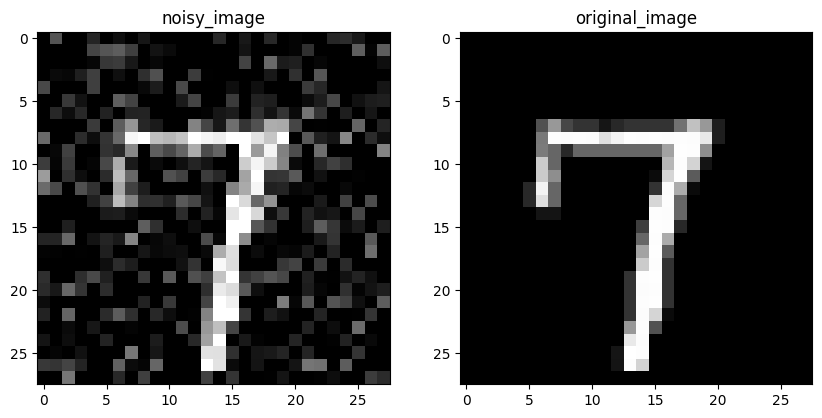

In [90]:
from helper import show_image
show_image(noisy_image,org_image) 

# Load dataset into batches

In [91]:
from torch.utils.data import DataLoader 

In [92]:
trainloader = DataLoader(trainset,batch_size = 16,shuffle = True)

In [93]:
for noisy_image, org_image in trainloader:
  break

print("Shape of loading one batch : {}".format(noisy_image.shape))
print("Shape of loading one batch : {}".format(org_image.shape))

print("Total no. of batches present in trainloader : {}".format(len(trainloader))) #total no. of batches
print("Total no. of examples present in trainloader : {}".format(len(trainloader.dataset)))

Shape of loading one batch : torch.Size([16, 1, 28, 28])
Shape of loading one batch : torch.Size([16, 1, 28, 28])
Total no. of batches present in trainloader : 2625
Total no. of examples present in trainloader : 42000


# Create AutoEncoder Model

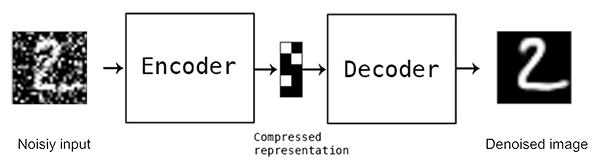

In [94]:
#Now we will create autoencoder for our denoising task
#First importing necessary libraries
import torch
from torch import nn
from torchsummary import summary

In [95]:
#At first creating encoder
def encoder():
  enc=nn.Sequential(
      nn.Conv2d(in_channels=1,out_channels=16,kernel_size=(3,3),padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2,2)),
      nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3),padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2,2)),

  )

  return enc

In [96]:
#Now creating decoder 
def decoder():
  dec=nn.Sequential(
      nn.ConvTranspose2d(in_channels=32,out_channels=16,kernel_size=(2,2),stride=2),
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=16,out_channels=1,kernel_size=(2,2),stride=2),
      nn.Sigmoid()
  )
  return dec

In [97]:
#Now creating AutoEncoder Model Class
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder,self).__init__()
    self.encoder=encoder()
    self.decoder=decoder()

  def forward(self,inp_images):
    enc_out=self.encoder(inp_images)
    dec_out=self.decoder(enc_out)

    return dec_out


model=AutoEncoder()

model.to('cuda')

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

In [98]:
summary(model,input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
   ConvTranspose2d-7           [-1, 16, 14, 14]           2,064
              ReLU-8           [-1, 16, 14, 14]               0
   ConvTranspose2d-9            [-1, 1, 28, 28]              65
          Sigmoid-10            [-1, 1, 28, 28]               0
Total params: 6,929
Trainable params: 6,929
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.38
Params size (MB): 0.03
Estimated Total

# Train AutoEncoder Model 

In [99]:
#Now import necessary libraries for training 
from torch import optim
from tqdm import tqdm

In [100]:
#Initializing the necessary hyperparameters
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
criterion=nn.MSELoss()
epochs=15

In [101]:
#Now running the training loop
for i in range(epochs):
  train_loss=0.0
  model.train()
  for batch in tqdm(trainloader):
    noisy_image,org_image=batch
    noisy_image=noisy_image.to('cuda')
    org_image=org_image.to('cuda')
    denoised_image=model(noisy_image)
    optimizer.zero_grad()
    loss=criterion(denoised_image,org_image)
    #optimizer work start
    
    loss.backward()
    optimizer.step()
    train_loss+=loss.item()

  
  print(f"Epoch{i}/{epochs} Training Loss: {train_loss/len(trainloader)}")


100%|██████████| 2625/2625 [00:44<00:00, 58.90it/s]


Epoch0/15 Training Loss: 0.016781348706356117


100%|██████████| 2625/2625 [00:40<00:00, 65.29it/s]


Epoch1/15 Training Loss: 0.005958696109730573


100%|██████████| 2625/2625 [00:44<00:00, 59.47it/s] 


Epoch2/15 Training Loss: 0.005524498161283278


100%|██████████| 2625/2625 [00:53<00:00, 49.12it/s]


Epoch3/15 Training Loss: 0.005319777243637613


100%|██████████| 2625/2625 [00:43<00:00, 60.75it/s]


Epoch4/15 Training Loss: 0.00517932022345208


100%|██████████| 2625/2625 [00:42<00:00, 61.26it/s]


Epoch5/15 Training Loss: 0.0050616303465905645


100%|██████████| 2625/2625 [00:43<00:00, 60.26it/s]


Epoch6/15 Training Loss: 0.00498837654035361


100%|██████████| 2625/2625 [00:49<00:00, 53.37it/s] 


Epoch7/15 Training Loss: 0.004927650049062712


100%|██████████| 2625/2625 [00:54<00:00, 47.84it/s]


Epoch8/15 Training Loss: 0.004877630073133679


100%|██████████| 2625/2625 [00:47<00:00, 55.16it/s]


Epoch9/15 Training Loss: 0.004840893608118807


100%|██████████| 2625/2625 [00:48<00:00, 54.38it/s]


Epoch10/15 Training Loss: 0.004804768016561866


100%|██████████| 2625/2625 [00:45<00:00, 58.26it/s]


Epoch11/15 Training Loss: 0.004768754110183744


100%|██████████| 2625/2625 [00:45<00:00, 57.42it/s]


Epoch12/15 Training Loss: 0.004743615121181522


100%|██████████| 2625/2625 [00:50<00:00, 52.33it/s]


Epoch13/15 Training Loss: 0.004721082594423067


100%|██████████| 2625/2625 [00:40<00:00, 64.14it/s] 

Epoch14/15 Training Loss: 0.004694988761629377


# Plot Results

torch.Size([1, 28, 28])


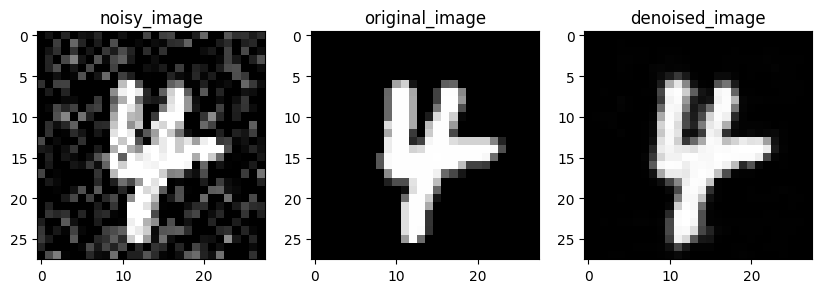

In [107]:
#Now we are visualizing results:
model.eval()

with torch.no_grad():
  for noisy_image,image in trainloader:
    break
    
  index=0
  pred_image=model(noisy_image[index].unsqueeze(0).to('cuda'))
  print(pred_image.squeeze(0).shape)
  show_image(noisy_image[index].to('cpu'),image[index],pred_image.squeeze(0).to('cpu'))